# Testing the Method on SANS-2D Data

## Setup

In [1]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
import esssans as sans
from esssans.types import *

import matplotlib.pyplot as plt

In [2]:
pipeline = sciline.Pipeline(
    sans.providers + sans.sans2d.providers,
    params=sans.sans2d.default_parameters,
)

In [3]:
pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
pipeline.insert(sans.transmission_from_background_run)
pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
pipeline.insert(sans.transmission_from_sample_run)
pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
pipeline[OutFilename] = 'reduced.nxs'

pipeline[WavelengthBins] = sc.linspace(
    'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
)

pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')

mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
pipeline[WavelengthMask] = sc.DataArray(
    sc.array(dims=['wavelength'], values=[True]),
    coords={'wavelength': mask_interval},
)

pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
pipeline[NonBackgroundWavelengthRange] = sc.array(
    dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
)
pipeline[CorrectForGravity] = True
pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
pipeline[sans.ReturnEvents] = True

## Explore the BackgroundSubtractedIofQ Output

This item apparently returns events.  Does it?  Examining this workflow it looks like it returns histogrammed data.  Examining the data in the output confirms this.

In [4]:
iofq = pipeline.get(BackgroundSubtractedIofQ)

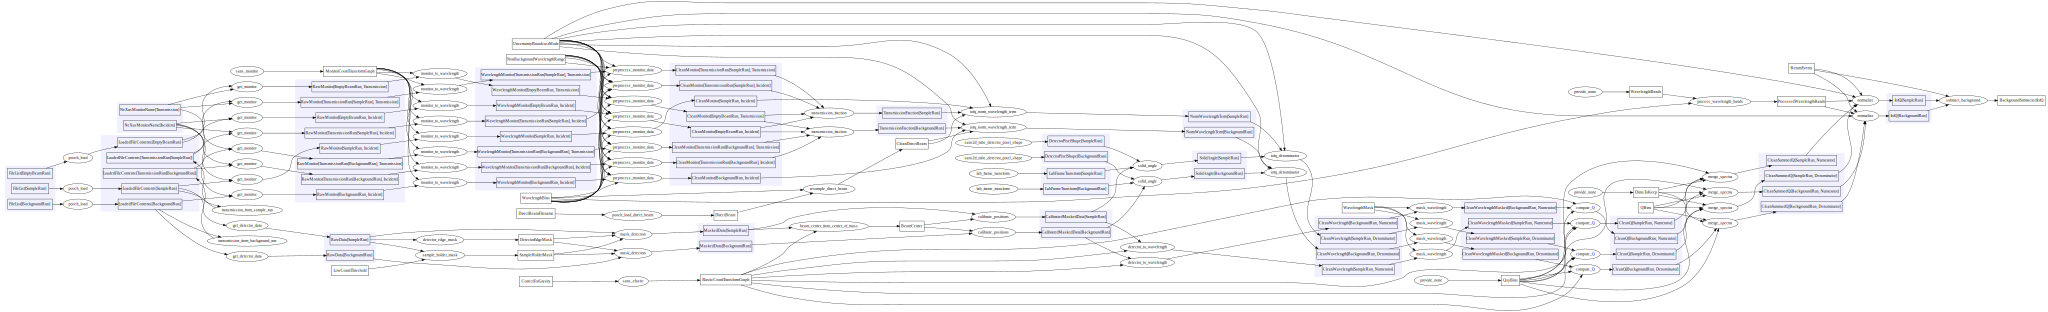

In [5]:
iofq.visualize(graph_attr={'rankdir': 'LR'})

In [6]:
sampiq = pipeline.get(BackgroundSubtractedIofQ)
sampres = sampiq.compute()

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


In [7]:
print(sampres)

<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                          DataArrayView        <no unit>  (Q)  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})




Note that the Q coords are bin edges, and the DataArrayView is "binned data".

Looking down at the data itself: 

In [17]:
svar = sampres.data
print(svar)

<scipp.Variable> (Q: 140)  DataArrayView        <no unit>  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})


* We have there 140 Q values.
* It has no units
* but 6M events, and coords there has Q.  What is that?

In [18]:
sc.show(svar)

In [28]:
sc.show(svar[139])

In [44]:
sc.show(svar[0].values)

In [47]:
sc.show(svar[0].values.data)

In [83]:
print(svar[0].values.data[0])
print(svar[0].values.data[20000])

<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05
<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05


That's the Q value and the weight as a pair?
However, these data values are all the same within each bin?

In [10]:
# Simon Heybrock suggested this to extract the events:
print(sampres[0].value)
sc.show(sampres[0].value)

<scipp.DataArray>
Dimensions: Sizes[event:22015, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.0128737, 0.0141552]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 1.27805, 1.638]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-14T05:38:44.839996337, 2020-02-14T05:56:34.838012695]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 85109, 79565.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 14.4611, 13.5191]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., -0.00235922, -0.00235922]  [3.303e-05, 3.303e-05, ..., 5.94507e-06, 5.94507e-06]




In [22]:
print(sampres[0].value[0])

<scipp.DataArray>
Dimensions: Sizes[]
Coordinates:
  Q                         float64           [1/Å]  ()  0.014073
  phi                       float64            [rad]  ()  -1.48244
  pulse_time              datetime64             [ns]  ()  2020-02-12T20:49:47.788024902
  tof                       float64            [µs]  ()  92788.1
  wavelength                float64             [Å]  ()  15.7654
Data:
                            float64  [dimensionless]  ()  0.003432  3.303e-05




In [26]:
print(sampres[0].value[0].coords['Q'].value) # The q value of the point
print(sampres[0].value[0].data.value) # the statistical weight?

0.014072992128883214
0.003431999959142457


In [31]:
allevents = sampres.bins.concat().value
print(allevents)

<scipp.DataArray>
Dimensions: Sizes[event:6172466, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.593805, 0.594188]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 2.41065, 2.3946]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-12T21:03:12.386108398, 2020-02-12T20:38:54.589000701]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 11876.9, 11848.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 2.01191, 2.0071]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., 3.58915, 3.58915]  [3.303e-05, 3.303e-05, ..., 19.0887, 19.0887]




In [72]:
eventQ = allevents.coords['Q'].values
eventW = allevents.values
nans = np.isnan(eventW)
print(nans)
eventW[nans] = 0.0
print(eventW)

[False False False ... False False False]
[ 3.43199996e-03  3.43199996e-03  3.43199996e-03 ... -1.63057064e+00
  3.58914659e+00  3.58914659e+00]


140
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




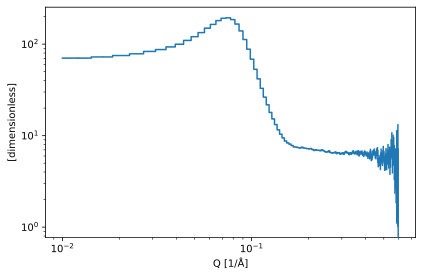

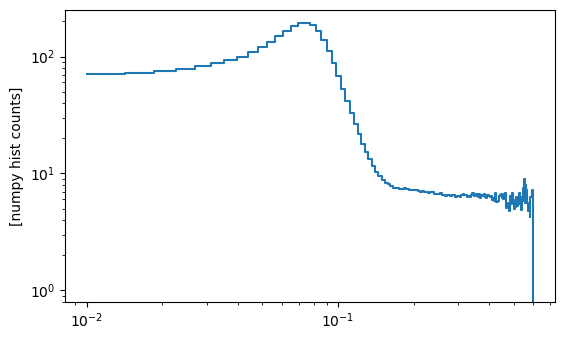

In [132]:
shst = sampres.hist()
print(shst.size)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

hstw = np.histogram(study_data, bins=scipp_bins, weights=eventW)
x_histw = hstw[1]
x_histw = x_histw[:-1]
y_histw = hstw[0]
e_histw = np.sqrt(y_histw)

hst = np.histogram(study_data, bins=scipp_bins)#, weights=np.sqrt(eventW))
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

#plt.errorbar(x_histw, y_histw, yerr=e_histw, label='Weighted')
#plt.errorbar(x_hist, y_hist, yerr=e_hist, label='Unweighted')
plt.step(x_histw, y_histw, where='post', label='Weighted')
#plt.plot(x_hist, scl*y_hist, label=scltxt)
plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.ylim([0.8, 250])
plt.ylabel('[numpy hist counts]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')


I wouldn't say this is absolutely identical, but it looks close enough to work with.  

Also maybe the bins are not optimal in scipp, and there are some odd artefacts going on in scipp if I plot my own optimal histogram.

{'Q': 140}
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1239/673282551.py:42: RuntimeWarning: invalid value encountered in sqrt
  e_hist = np.sqrt(y_hist)


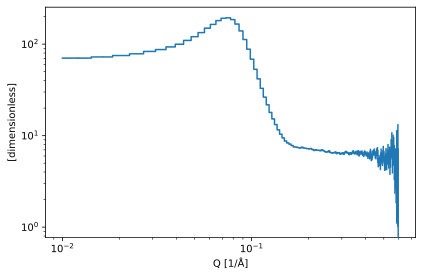

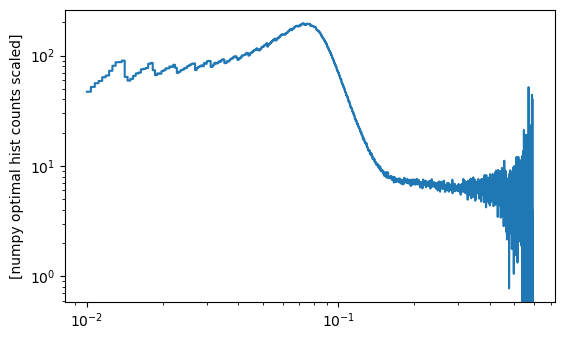

In [134]:
shst = sampres.hist()
print(shst.sizes)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

nscipp_bins = shst.size


def optimal_linear_nbins(xevents):
    """
    Calculate optimal number of bins from Freedman-Diaconis rule
    https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
    https://en.wikipedia.org/wiki/Freedman–Diaconis_rule
    """
    xmax = np.amax(xevents)
    xmin = np.amin(xevents)

    npts = xevents.size
    
    iqr = np.subtract(*np.percentile(xevents, [75, 25]))
    return int((xmax - xmin)*npts**(1.0/3.0)/(2.0*iqr))


study_data = eventQ

opt_n_bin = optimal_linear_nbins(study_data)

event_xmax = np.amax(study_data)
event_xmin = np.amin(study_data)

slic=(event_xmax-event_xmin)/(opt_n_bin+1)
hbins = np.arange(event_xmin, event_xmax, slic)

hscale =  float(opt_n_bin) /float(nscipp_bins)

hst = np.histogram(study_data, bins=hbins, weights=eventW)
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

plt.step(x_hist, y_hist*hscale, where='post', label='Weighted')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('[numpy optimal hist counts scaled]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')
